In [90]:
import os
CONLIT_DIR = "../data/experiments/testsets/conlit/"
BOOKNLP_DIR = os.path.join (CONLIT_DIR, "booknlp")
EXAMPLES_DIR = os.path.join (CONLIT_DIR, "examples")
PREDICTIONS_DIR = os.path.join (CONLIT_DIR, "predictions")
ANALYSIS_DIR = os.path.join (CONLIT_DIR, "analysis")
BOOK_IDS_FILE = os.path.join (CONLIT_DIR, "conlit.ids")
CONLIT_META_FILE = os.path.join (CONLIT_DIR, "CONLIT_META.csv")

## Other Constants
TOP_CHARS = 10

In [385]:
import json
import math
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from gensim.models import Word2Vec

import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter, defaultdict

# Importing the geodesic module from the library
from geopy.distance import geodesic

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 8.0
%matplotlib inline

### Get Character and Gender Info Per Book

In [63]:
def get_char_frequency (book_ids, booknlp_dir):
    """ Get the counts of each individual character in a book"""
    char_freqs = dict ()
    for book_id in tqdm (book_ids):
        book_file = os.path.join (booknlp_dir, f"{book_id}.book")
        if os.path.exists (book_file):
            with open (book_file) as fin:
                js = json.loads (fin.read ())
            char_freqs [book_id] = {char["id"]: char["count"] for char in js["characters"]}
    return char_freqs

def get_inferential_gender (book_ids, booknlp_dir):
    """ Get the inferential gender of each individual character in a book"""
    gender_inf = dict ()
    for book_id in tqdm (book_ids):
        book_file = os.path.join (booknlp_dir, f"{book_id}.book")
        if os.path.exists (book_file):
            with open (book_file) as fin:
                js = json.loads (fin.read ())
            gender_inf [book_id] = {char["id"]: char["g"]["argmax"] for char in js["characters"] if char["g"] is not None}
    return gender_inf

def get_top_chars (char_freqs, gender_inf, k=10):
    """ Filter the top k characters """
    top_char_freqs = dict ()
    top_gender_inf = dict ()
    for book_id in char_freqs:
        items = sorted (char_freqs[book_id].items(), key=lambda x:x[1], reverse=True)[0:k]
        req_char_ids = [char_id for char_id, _ in items]
        top_char_freqs[book_id] = {char_id: char_freqs[book_id][char_id] 
                                     for char_id in char_freqs[book_id] 
                                     if char_id in req_char_ids}
        top_gender_inf[book_id] = {char_id: gender_inf[book_id][char_id] 
                                     for char_id in gender_inf[book_id] 
                                     if char_id in req_char_ids}
        
    return top_char_freqs, top_gender_inf

def readBookIDsFromFile (filename):
    """ Read the book IDs from an index file"""
    with open (filename) as fin:
        book_ids = [line.rstrip('\n') for line in fin]
    return book_ids

In [61]:
book_ids = readBookIDsFromFile (BOOK_IDS_FILE)
char_freqs = get_char_frequency (book_ids, BOOKNLP_DIR)
gender_inf = get_inferential_gender (book_ids, BOOKNLP_DIR)
top_char_freqs, top_gender_inf = get_top_chars(char_freqs, gender_inf, k=TOP_CHARS)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2754/2754 [01:05<00:00, 42.21it/s]


### Get all the predictions for the individual characters in a book

In [305]:
def char_locations_by_story_time (df):
    predictions = dict ()
    for i, row in df.iterrows ():
        char_id = row["char_coref"]
        if char_id not in predictions:
            predictions[char_id] = []
        predictions[char_id].append (row["place_text"])
    return predictions

def get_char_predictions (book_ids, 
                          top_chars,
                          predictions_dir, 
                          examples_dir, 
                          place_cats=[("GPE", "PROP")],
                          upto=10000):
    char_predictions = dict ()
    for book_id in tqdm(book_ids):
        chars = top_chars[book_id]
        if book_id not in char_predictions:
            char_predictions[book_id] = {char: list () for char in chars} # initialize dictionary
            
        # read the predictions and the collocations from file for every book
        predictions_file = os.path.join (predictions_dir, f"{book_id}.predictions")
        collocations_file = os.path.join (examples_dir, f"{book_id}.collocations")
        if os.path.exists (predictions_file) and os.path.exists (collocations_file):
            predictions_df = pd.read_csv (predictions_file, sep='\t')
            collocations_df = pd.read_csv (collocations_file, sep='\t')
        
            # trim the predictions dataframe
            predictions_df = predictions_df[["book_id", "ID", "validity", "spatial"]]
            predictions_df = predictions_df.query ('validity == "VALID" and spatial == "IN"')
        
            # trim the collocations frame
            collocations_df = collocations_df.sort_values (by="char_start_token")
            collocations_df = collocations_df.query ('char_start_token < @upto')
            collocations_df = collocations_df[['char_text', 
                                               'char_coref', 
                                               'char_cat', 
                                               'place_text', 
                                               'place_coref',
                                               'place_cat',
                                               'place_tag',
                                               'ID']]
            
            # Construct the place category queries
            ## categories can be one of {GPE, FAC, LOC}
            ## If category is GPE then the tag should be PROP;
            ## Otherwise the tag does not matter
            place_cat_subqueries = []
            for cat, tag in place_cats:
                if tag is not None:
                    place_cat_subqueries.append (f'(place_cat == "{cat}" and place_tag == "{tag}")')
                else:
                    place_cat_subqueries.append (f'(place_cat == "{cat}")')
            
            place_cat_query_string = " or ".join (place_cat_subqueries)
            
            # Execute the place category query strings
            collocations_df = collocations_df.query (place_cat_query_string)
        
            # join the two dataframes
            joint_df = pd.merge (predictions_df, collocations_df, how="inner", on="ID")
            
            # Now extract the predictions from the joint_df that are specific to just the top characters
            joint_df = joint_df.query ('char_coref in @chars')
            predictions = char_locations_by_story_time (joint_df)
            char_predictions[book_id].update (predictions)
    return char_predictions

In [306]:
num_words = [10000, 20000, 40000, 80000, 160000, 320000]
char_gpe_places = dict ()
char_nongpe_places = dict ()
char_all_places = dict ()

for words in num_words:
    char_gpe_places[words] = get_char_predictions (book_ids, 
                                                   top_char_freqs,
                                                   PREDICTIONS_DIR, 
                                                   EXAMPLES_DIR, 
                                                   place_cats=[("GPE", "PROP")],
                                                   upto=words)
    
    char_nongpe_places[words] = get_char_predictions (book_ids, 
                                                      top_char_freqs,
                                                      PREDICTIONS_DIR, 
                                                      EXAMPLES_DIR, 
                                                      place_cats=[("FAC", None), 
                                                                  ("LOC", None)],
                                                      upto=words)
    
    
    char_all_places[words] = get_char_predictions (book_ids, 
                                                   top_char_freqs,
                                                   PREDICTIONS_DIR, 
                                                   EXAMPLES_DIR, 
                                                   place_cats=[("GPE", "PROP"), 
                                                               ("FAC", None), 
                                                               ("LOC", None)],
                                                   upto=words)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2754/2754 [05:58<00:00,  7.68it/s]


In [308]:
def get_avg_hop_mob (char_predictions):
    avg_mob_book = dict ()
    for book_id in char_predictions:
        avg_mob_book[book_id] = sum ([len (set (char_predictions[book_id][char_id])) 
                                      for char_id in char_predictions[book_id]])
        
        avg_mob_book[book_id] = avg_mob_book[book_id] / len (char_predictions[book_id])
    
    return avg_mob_book

avg_gpe_hop_mob = dict ()
avg_nongpe_hop_mob = dict ()
avg_all_hop_mob = dict ()

for words in num_words:
    avg_gpe_hop_mob[words] = get_avg_hop_mob (char_gpe_places[words])
    avg_nongpe_hop_mob[words] = get_avg_hop_mob (char_nongpe_places[words])
    avg_all_hop_mob[words] = get_avg_hop_mob (char_all_places[words])

In [309]:
# Create a dataframe and write to file
def create_dataframe(nested_dict, field_name="avg_gpe_hop_mob"):
    """
    Creates a Pandas DataFrame from a nested dictionary.
    
    Args:
    nested_dict: A nested dictionary.

    Returns:
    A Pandas DataFrame.
    """
    rows = list ()
    for k1 in nested_dict:
        for k2 in nested_dict[k1]:
            rows.append ([k2, k1, nested_dict[k1][k2]])
    df = pd.DataFrame (rows, columns=["book_id", "num_words", field_name])
    return df

gpe_hop_mob_df = create_dataframe (avg_gpe_hop_mob, field_name="avg_gpe_hop_mob")
nongpe_hop_mob_df = create_dataframe (avg_nongpe_hop_mob, field_name="avg_nongpe_hop_mob")
all_hop_mob_df = create_dataframe (avg_all_hop_mob, field_name="avg_all_hop_mob")

In [310]:
gpe_hop_mob_df.query('num_words == 40000').sort_values (by='avg_gpe_hop_mob', ascending=False).head (20)

,book_id,num_words,avg_gpe_hop_mob
8163,"Queen Isabella - Weir, Alison",40000,15.5
6973,"2014_VonFurstenberg,Diane_TheWomanIWantedtoBe_ME",40000,13.7
7940,41 A Portrait of My Father - George W. Bush,40000,13.0
6180,"2012_Niven,Penelope_ThortonWilder_NF",40000,11.1
8022,Elizabeth of York_ A Tudor Queen and Her World...,40000,10.3
8033,FDR - Jean Edward Smith,40000,10.0
5765,"2010_Bush,GeorgeW_DecisionPoints_ME",40000,9.8
8158,Prince Charles - Sally Bedell Smith,40000,9.5
7453,"2016_Behrens,Peter_CarryMe_CT",40000,9.1
8131,Mary Boleyn - Alison Weir,40000,8.9


In [311]:
all_hop_mob_df.query('num_words == 40000').sort_values (by='avg_all_hop_mob', ascending=False).head (20)

,book_id,num_words,avg_all_hop_mob
6973,"2014_VonFurstenberg,Diane_TheWomanIWantedtoBe_ME",40000,42.7
6556,"2013_Winter,Michael_MinisterWithoutPortfolio_CT",40000,38.3
7940,41 A Portrait of My Father - George W. Bush,40000,36.9
7008,"2015_Alda,Arlene_JustKidsfromtheBronx_ME",40000,36.7
7453,"2016_Behrens,Peter_CarryMe_CT",40000,36.2
6484,"2013_RaeMiller,Kimberly_ComingClean_ME",40000,35.7
7456,"2016_Berry,Flynn_UnderTheHarrow_CT",40000,35.3
7745,"2016_Pinckney,Darryl_BlackDeutschland_CT",40000,34.3
6797,"2014_Lockhart,E._WeWereLiars_YA",40000,33.8
5766,"2010_Bush,Laura_SpokenfromtheHeart_ME",40000,33.7


In [312]:
def remove_duplicates (items):
    last_item = ''
    uniques = list ()
    for item in items:
        if not item == last_item:
            uniques.append (item)
        last_item = item

    return uniques
            
def get_toponyms (toponyms_file):
    rows = list ()
    with open (toponyms_file) as fin:
        for line in fin:
            js = json.loads (line.strip())
            row = [js["book_id"], js["coref_id"], js["text"], js["country_short"], js["admin_1_short"], js["lat"], js["lon"]]
            rows.append (row)

    toponyms = pd.DataFrame (rows, columns=["book_id",
                                        "place_coref",
                                        "text",
                                        "country_short",
                                        "admin_1_short",
                                        "lat",
                                        "lon"])
    return toponyms

def consecutive_items_generator(lst):
    if len(lst) == 1:
        yield lst[0], None
    else:
        for i in range(len(lst) - 1):
            yield lst[i], lst[i+1]

def get_avg_dist_mob (char_predictions, top_dict):
    avg_mob_book = dict ()
    for book_id in tqdm (char_predictions):
        avg_mob_book[book_id] = 0
        for char in char_predictions[book_id]:
            seq = remove_duplicates (char_predictions[book_id][char])
            lat_lons = [top_dict.get (item, ()) for item in seq]
            lat_lons = [item for item in lat_lons if len (item) > 0]
            for before, after in consecutive_items_generator (lat_lons):
                if after is not None:
                    avg_mob_book[book_id] += geodesic (before, after).miles
        
        avg_mob_book[book_id] = avg_mob_book[book_id] / len (char_predictions[book_id])
    
    return avg_mob_book

toponyms = get_toponyms (os.path.join (ANALYSIS_DIR, "toponym_resolution.example.jsonl"))
top_dict = {row["text"]: (row["lat"], row["lon"]) for i, row in toponyms.iterrows ()}
avg_gpe_dist_mob = dict ()
for words in num_words:
    avg_gpe_dist_mob[words] = get_avg_dist_mob (char_gpe_places[words], top_dict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2754/2754 [00:38<00:00, 71.34it/s]


In [313]:
gpe_dist_mob_df = create_dataframe (avg_gpe_dist_mob, field_name="avg_gpe_dist_mob")
gpe_dist_mob_df.query('num_words == 40000').sort_values (by='avg_gpe_dist_mob', ascending=False).head (20)

,book_id,num_words,avg_gpe_dist_mob
6180,"2012_Niven,Penelope_ThortonWilder_NF",40000,59417.906621
6973,"2014_VonFurstenberg,Diane_TheWomanIWantedtoBe_ME",40000,51742.932429
7003,"2015_Addario,Lynsey_ItsWhatIDo_ME",40000,47724.323184
6497,"2013_Ripley,Amanda_TheSmartestKidsintheWorld_NF",40000,42582.065937
8163,"Queen Isabella - Weir, Alison",40000,40107.124199
7374,"2015_Strauss,Barry_TheDeathofCaesar_HIST",40000,38678.648442
8158,Prince Charles - Sally Bedell Smith,40000,37241.205553
6771,"2014_Kim,Suki_WithoutYouThereisNoUs_ME",40000,34348.092076
7949,Alibaba_ The House That Jack Ma Built - Duncan...,40000,32319.411046
7940,41 A Portrait of My Father - George W. Bush,40000,32204.404116


In [318]:
common_cols = ["book_id", "num_words"]
join_type= "inner"

book_mobility_df = gpe_hop_mob_df.merge (nongpe_hop_mob_df, on=common_cols, how=join_type) \
                                 .merge (all_hop_mob_df, on=common_cols, how=join_type) \
                                 .merge (gpe_dist_mob_df, on=common_cols, how=join_type)
book_mobility_df.head (5)

,book_id,num_words,avg_gpe_hop_mob,avg_nongpe_hop_mob,avg_all_hop_mob,avg_gpe_dist_mob
0,[Heist Society 2] Uncommon Criminals - Ally Ca...,10000,0.5,2.4,2.9,972.099758
1,"2001_2011_Wilson,RobertCharles_TheChronoliths_SF",10000,0.6,4.0,4.6,1707.471879
2,"2001_Martel,Yann_LifeofPi_BS",10000,0.7,2.0,2.7,8199.108686
3,"2002_2011_Anderson,MT_Feed_SF",10000,0.0,2.3,2.3,0.000000
4,"2002_Baker,Jo_Offcomer_CT",10000,0.7,3.9,4.6,0.000000


In [357]:
conlit_meta_df = pd.read_csv (CONLIT_META_FILE)
conlit_meta_df["ID"] = conlit_meta_df["ID"].apply (lambda x: x[:-4])

overall_book_mob_df = book_mobility_df.merge (conlit_meta_df, 
                                              left_on="book_id", 
                                              right_on="ID", 
                                              how="inner")
overall_book_mob_df = overall_book_mob_df.drop ("ID", axis=1)

In [359]:
overall_book_mob_df.to_csv (os.path.join (ANALYSIS_DIR, "book_mobility.tsv"), sep="\t", header=True, index=False)

Definitions of different variables [here](https://storage.googleapis.com/jnl-up-j-johd-files/journals/1/articles/88/submission/proof/88-1-1498-1-10-20221011.pdf)

Text(0, 0.5, 'Average Distance (miles)')

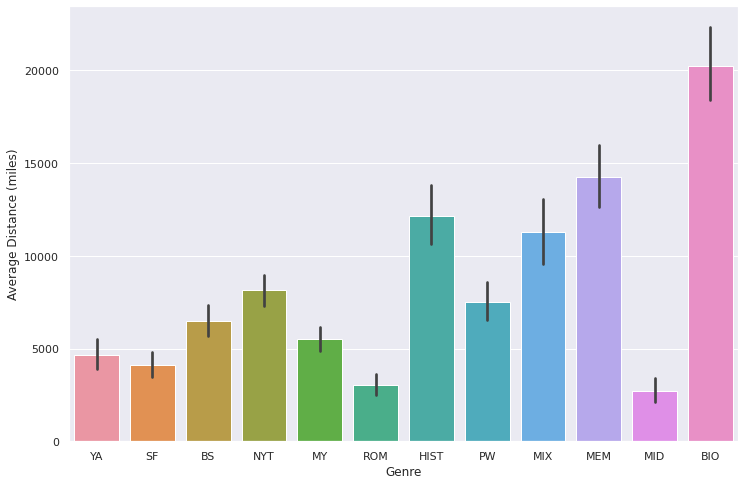

In [455]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(data=overall_book_mob_df.query ('num_words == 80000'), x="Genre", y="avg_gpe_dist_mob")
plt.ylabel ("Average Distance (miles)")

Text(0, 0.5, 'Average Distance (miles)')

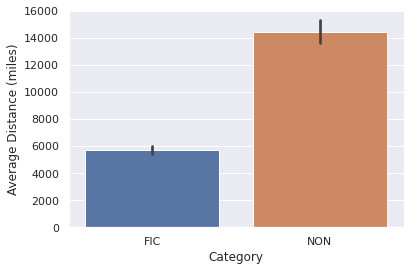

In [458]:
sns.set(rc={'figure.figsize':(6,4)})
sns.barplot(data=overall_book_mob_df.query ('num_words == 80000'), x="Category", y="avg_gpe_dist_mob")
plt.ylabel ("Average Distance (miles)")

Text(0, 0.5, 'Average Distance (miles)')

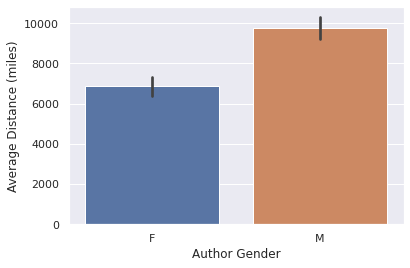

In [464]:
sns.set(rc={'figure.figsize':(6,4)})
binary_genders = ["M", "F"]
sns.barplot(data=overall_book_mob_df.query ('num_words == 80000 and Author_Gender in @binary_genders'), x="Author_Gender", y="avg_gpe_dist_mob")
plt.xlabel ("Author Gender")
plt.ylabel ("Average Distance (miles)")

Text(0, 0.5, 'Average Distance (miles)')

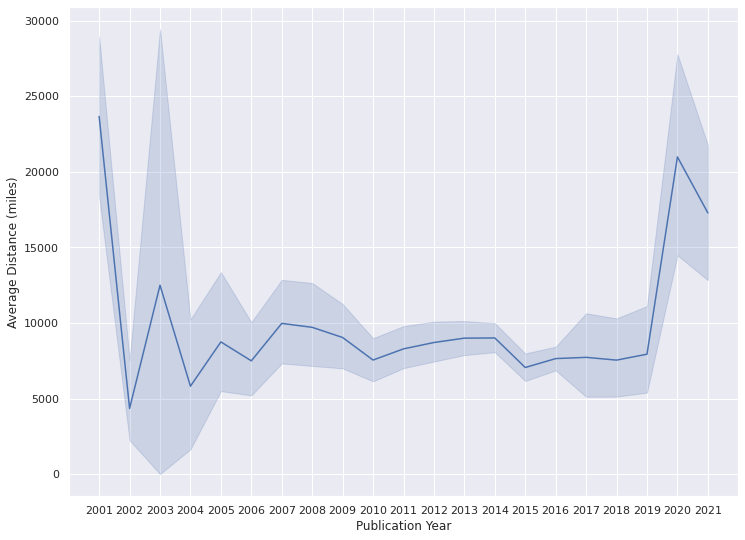

In [470]:
sns.set(rc={'figure.figsize':(12,9)})
# Plot the responses for different events and regions
ax = sns.lineplot(x="Pubdate", y="avg_gpe_dist_mob", markers=True,
             data=overall_book_mob_df.query ('num_words == 80000'))
ax.set(xticks=overall_book_mob_df.query ('num_words == 80000')["Pubdate"].unique())
ax.set_xlabel ("Publication Year")
ax.set_ylabel ("Average Distance (miles)")

Text(0, 0.5, 'Average Distance (miles)')

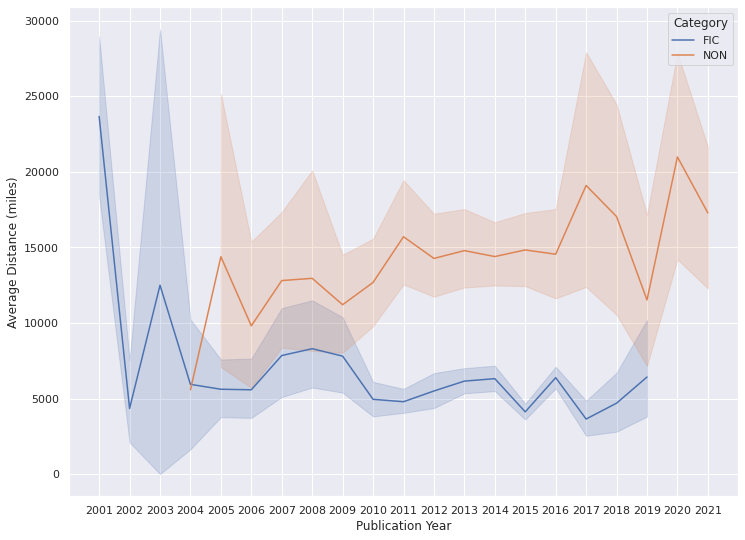

In [473]:
sns.set(rc={'figure.figsize':(12,9)})
# Plot the responses for different events and regions
ax = sns.lineplot(x="Pubdate", y="avg_gpe_dist_mob", markers=True, hue="Category",
             data=overall_book_mob_df.query ('num_words == 80000'))
ax.set(xticks=overall_book_mob_df.query ('num_words == 80000')["Pubdate"].unique())
ax.set_xlabel ("Publication Year")
ax.set_ylabel ("Average Distance (miles)")

[[<matplotlib.axis.XTick at 0x7f8cd4156820>,

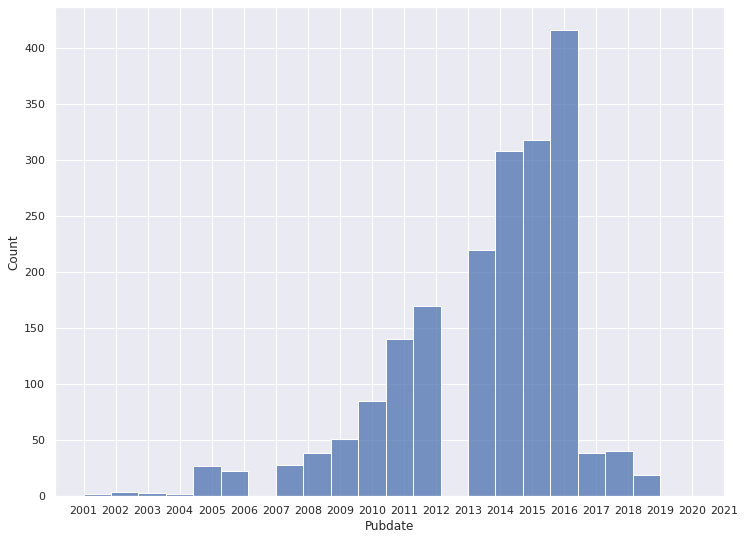

In [484]:
sns.set(rc={'figure.figsize':(12,9)})
ax = sns.histplot (data=conlit_meta_df.query ("Category == 'FIC'"), x="Pubdate", bins=21)
ax.set(xticks=conlit_meta_df["Pubdate"].unique())
#conlit_meta_df.query ("Category == 'FIC'")["Pubdate"].hist(bins=20)

Text(0.5, 1.0, 'Yearly distribution of fiction books in conlit')

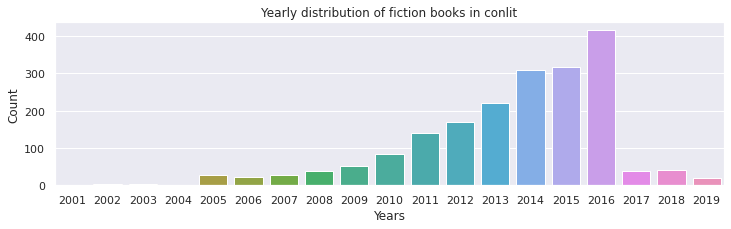

In [488]:
sns.set(rc={'figure.figsize':(12,3)})
# Convert counter to a DataFrame or a list
data = pd.DataFrame.from_dict(Counter (conlit_meta_df.query ("Category == 'FIC'")["Pubdate"]), orient='index', columns=['Count'])
# Alternatively, you can use a list of values
# data = list(counter.values())

# Create bar plot using seaborn
sns.barplot(x=data.index, y='Count', data=data)

# Add labels and title
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Yearly distribution of fiction books in conlit')

Text(0.5, 1.0, 'Yearly distribution of non-fiction books in conlit')

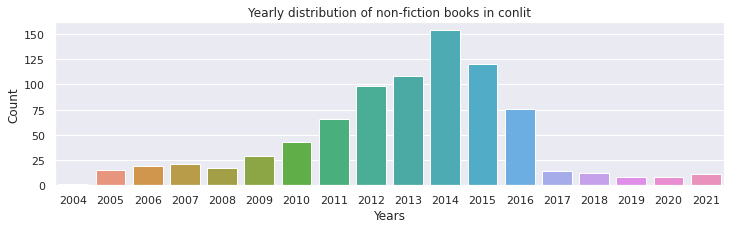

In [489]:
sns.set(rc={'figure.figsize':(12,3)})
# Convert counter to a DataFrame or a list
data = pd.DataFrame.from_dict(Counter (conlit_meta_df.query ("Category == 'NON'")["Pubdate"]), orient='index', columns=['Count'])
# Alternatively, you can use a list of values
# data = list(counter.values())

# Create bar plot using seaborn
sns.barplot(x=data.index, y='Count', data=data)

# Add labels and title
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Yearly distribution of non-fiction books in conlit')

In [440]:
overall_char_mob_df = list ()
for words in num_words:
    rows = list ()
    for book_id in char_gpe_places[words]:
        for char_id in char_gpe_places[words][book_id]:
            seq = remove_duplicates (char_gpe_places[words][book_id][char_id])
            mob_dist = 0
            lat_lons = [top_dict.get (item, ()) for item in seq] #top_dict is a toponyms dictionary initialized earlier 
            lat_lons = [item for item in lat_lons if len (item) > 0]
            for before, after in consecutive_items_generator (lat_lons):
                if after is not None:
                    mob_dist += geodesic (before, after).miles 
            
            rows.append ([book_id, 
                         char_id, 
                         top_char_freqs[book_id][char_id],
                         top_gender_inf[book_id].get (char_id, None),
                         char_gpe_places[words][book_id][char_id],
                         len(set(char_gpe_places[words][book_id][char_id])), 
                         char_nongpe_places[words][book_id][char_id],
                         len (set (char_nongpe_places[words][book_id][char_id])), 
                         char_all_places[words][book_id][char_id],
                         len (set (char_all_places[words][book_id][char_id])), 
                         seq,
                         mob_dist
                         ])
    df = pd.DataFrame (rows, columns=["book_id", 
                                      "char_id", 
                                      "char_count", 
                                      "inf_gender", 
                                      "gpe_places",
                                      "num_gpe_places",
                                      "nongpe_places",
                                      "num_nongpe_places",
                                      "all_places",
                                      "num_all_places",
                                      "gpe_sequences",
                                      "dist_miles"])
    df['char_rank'] = df.groupby("book_id")['char_count'].rank(method='min', ascending=False)
    df["num_words"] = words
    overall_char_mob_df.append (df)

overall_char_mob_df = pd.concat (overall_char_mob_df)

In [441]:
overall_char_mob_df.to_csv (os.path.join (ANALYSIS_DIR, "book_char_mobility.tsv"), sep="\t", header=True, index=False)

Text(0, 0.5, 'Distance (miles)')

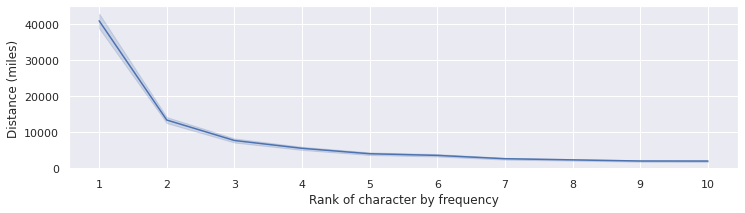

In [494]:
sns.set(rc={'figure.figsize':(12,3)})
ax = sns.lineplot(data=overall_char_mob_df.query ('num_words == 80000'), x="char_rank", y="dist_miles", markers=True)
ax.set(xticks=overall_char_mob_df.query ('num_words == 80000')["char_rank"].unique())
ax.set_xlabel ("Rank of character by frequency")
ax.set_ylabel ("Distance (miles)")

Text(0, 0.5, 'Distance (miles)')

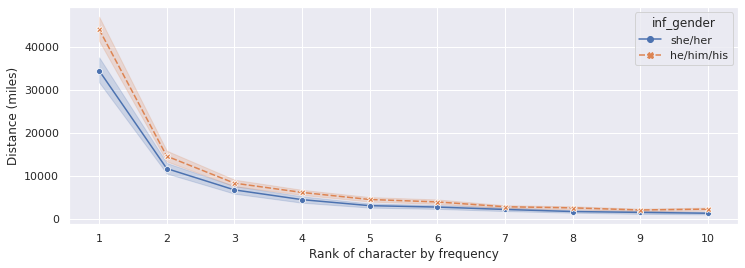

In [497]:
sns.set(rc={'figure.figsize':(12,4)})
binary_genders = ["she/her", "he/him/his"]
ax = sns.lineplot(data=overall_char_mob_df.query ('num_words == 80000 and inf_gender in @binary_genders'), x="char_rank", y="dist_miles", hue="inf_gender", style="inf_gender", markers=True)
ax.set(xticks=overall_char_mob_df.query ('num_words == 80000 and inf_gender in @binary_genders')["char_rank"].unique())
ax.set_xlabel ("Rank of character by frequency")
ax.set_ylabel ("Distance (miles)")

Text(0, 0.5, 'Distance (miles)')

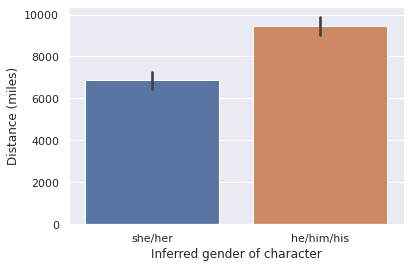

In [499]:
sns.set(rc={'figure.figsize':(6,4)})
binary_genders = ["she/her", "he/him/his"]
ax = sns.barplot(data=overall_char_mob_df.query ('num_words == 80000 and inf_gender in @binary_genders'), x="inf_gender", y="dist_miles")
ax.set_xlabel ("Inferred gender of character")
ax.set_ylabel ("Distance (miles)")

### Network generation

We can create a directional network of all the places 

In [500]:
'''
Reference implementation of node2vec. 

Author: Aditya Grover

For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016

Copied from https://github.com/aditya-grover/node2vec/
'''

class Graph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length, verbose=False):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        if verbose: print ('Walk iteration:')
        for walk_iter in range(num_walks):
            if verbose: print (str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]
    
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [[str(item) for item in walk] for walk in walks]
    model = Word2Vec(walks, vector_size=100, window=10, min_count=0, sg=1, workers=8, epochs=10)
    #model.save_word2vec_format(args.output)

    return model

In [501]:
def splitdoc (doc):
    return doc.split(';')

def get_bigram_counts (places, num_words):
    bigram_counts = dict ()

    # Collect bigrams that are present in at least 10 different characters
    vec = CountVectorizer (input='content', 
                           lowercase=True, 
                           ngram_range=(2,2), 
                           min_df=5, # retain place names that have been used by at least 10 characters 
                           max_df=0.9, # drop places that are used by more than 90% of the characters 
                           tokenizer=splitdoc, 
                           max_features=1000)

    for words in num_words:
        X = vec.fit_transform ([";".join(remove_duplicates([item.replace (' ', '_') for item in places[words][book_id][char_id] if type (item) == str])) 
                                         for book_id in places[words] 
                                         for char_id in places[words][book_id]])

        feat_names = vec.get_feature_names()
        bigram_counts[words] = {feat_name: X[:,i].sum() for i, feat_name in enumerate (feat_names)}

    return bigram_counts

char_gpe_bigram_counts = get_bigram_counts (char_gpe_places, num_words)
char_nongpe_bigram_counts = get_bigram_counts (char_nongpe_places, num_words)
char_all_bigram_counts = get_bigram_counts (char_all_places, num_words)

In [502]:
def node2vec_analysis (node2vec_params, num_words, bigram_counts, num_walks=1000, verbose=False):
    node2vec_models = dict ()
    networks = dict ()
    for p, q in node2vec_params:
        node2vec_models[(p,q)] = dict ()
        networks[(p,q)] = dict ()
        for words in num_words:
            # Create a directed graph object
            nx_G = nx.DiGraph()
            triples = [(feat_name.split ()[0], feat_name.split()[1], bigram_counts[words][feat_name]) for feat_name in bigram_counts[words]]
            # Iterate over the triples and add nodes and edges to the graph
            for src, tgt, count in triples:
                nx_G.add_edge(src, tgt, weight=count)
    
            G = Graph(nx_G, True, p, q)
            G.preprocess_transition_probs()
            walks = G.simulate_walks(num_walks, 80)
            node2vec_models[(p,q)][words]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         = learn_embeddings(walks)
            networks[(p,q)][words] = nx_G
        if verbose: print (f"All models for p={p}, q={q} are processed.")
            
    return node2vec_models, networks

In [504]:
node2vec_params = [(1.0, 1.0), (1.0, 0.1), (1.0, 10.0)]
gpe_node2vec_models, gpe_networks = node2vec_analysis (node2vec_params, num_words, char_gpe_bigram_counts, num_walks=1000, verbose=True)
nongpe_node2vec_models, nongpe_networks = node2vec_analysis (node2vec_params, num_words, char_nongpe_bigram_counts, num_walks=1000, verbose=True)
all_node2vec_models, all_networks = node2vec_analysis (node2vec_params, num_words, char_all_bigram_counts, num_walks=1000, verbose=True)

All models for p=1.0, q=1.0 are processed.
All models for p=1.0, q=0.1 are processed.
All models for p=1.0, q=10.0 are processed.
All models for p=1.0, q=1.0 are processed.
All models for p=1.0, q=0.1 are processed.
All models for p=1.0, q=10.0 are processed.
All models for p=1.0, q=1.0 are processed.
All models for p=1.0, q=0.1 are processed.
All models for p=1.0, q=10.0 are processed.


In [275]:
def write_edgelists (networks, node2vec_models, node2vec_params, num_words, outfile):
    edgelists = list ()
    for p,q in node2vec_params:
        for words in num_words:
            df = nx.to_pandas_edgelist (networks[(p, q)][words], source="source", target="target")
            df["cosine_sim"] = df.apply (lambda x:node2vec_models[(p,q)][words].wv.similarity(x['source'], x['target']), axis=1)
            df["p"] = p
            df["q"] = q
            df["words_cutoff"] = words
            edgelists.append (df)

    all_edges = pd.concat (edgelists)
    all_edges.to_csv (outfile, sep='\t', index=False, header=True)
    return all_edges

#gpe_edgelists = write_edgelists (gpe_networks, gpe_node2vec_models, node2vec_params, num_words, "gpe_network_edgelist.tsv")
#nongpe_edgelists = write_edgelists (nongpe_networks, nongpe_node2vec_models, node2vec_params, num_words, "nongpe_network_edgelist.tsv")
#all_edgelists = write_edgelists (all_networks, all_node2vec_models, node2vec_params, num_words, "all_network_edgelist.tsv")

In [505]:
def most_central (centralities, k=10):
    items = sorted (centralities.items(), key=lambda x:x[1], reverse=True)[0:k]
    return items

def print_centrality (network, k=10):
    print ("Indegree centrality")
    pp.pprint (most_central(nx.in_degree_centrality (network), k=10))
    print ("Outdegree centrality")
    pp.pprint (most_central(nx.out_degree_centrality (network), k=10))
    print ("Betweenness centrality")
    pp.pprint (most_central(nx.betweenness_centrality (network), k=10))
    print ("Edge betweenness centrality")
    pp.pprint (most_central(nx.edge_betweenness_centrality (network), k=10))

In [510]:
print_centrality (gpe_networks[(1.0, 1.0)][80000], k=10)

Indegree centrality
[   ('new_york', 0.2611464968152866),
    ('america', 0.14331210191082802),
    ('london', 0.1337579617834395),
    ('california', 0.09872611464968153),
    ('washington', 0.09554140127388536),
    ('paris', 0.08598726114649682),
    ('england', 0.07961783439490447),
    ('chicago', 0.07643312101910829),
    ('boston', 0.07006369426751592),
    ('rome', 0.054140127388535034)]
Outdegree centrality
[   ('new_york', 0.2929936305732484),
    ('america', 0.1464968152866242),
    ('london', 0.1305732484076433),
    ('washington', 0.1178343949044586),
    ('paris', 0.089171974522293),
    ('california', 0.08280254777070065),
    ('england', 0.07961783439490447),
    ('virginia', 0.06050955414012739),
    ('boston', 0.054140127388535034),
    ('rome', 0.04777070063694268)]
Betweenness centrality
[   ('new_york', 0.245066930762431),
    ('america', 0.09014963483551645),
    ('london', 0.0728524155349874),
    ('washington', 0.05370713157460251),
    ('california', 0.03967187

In [285]:
gpe_edgelists.query ('p == 1.0 and q == 10.0 and words_cutoff ==40000').sort_values (by="cosine_sim", ascending=False).head (10)

,source,target,weight,cosine_sim,p,q,words_cutoff
751,japan,tokyo,8,0.999809,1.0,10.0,40000
752,tokyo,japan,6,0.999809,1.0,10.0,40000
840,sweden,stockholm,17,0.999786,1.0,10.0,40000
839,stockholm,sweden,14,0.999786,1.0,10.0,40000
826,vietnam,hanoi,6,0.994443,1.0,10.0,40000
760,kigali,rwanda,7,0.992684,1.0,10.0,40000
805,yale,new_haven,11,0.992636,1.0,10.0,40000
804,new_haven,yale,11,0.992636,1.0,10.0,40000
674,colorado,denver,7,0.992319,1.0,10.0,40000
675,denver,colorado,9,0.992319,1.0,10.0,40000


In [545]:
print (gpe_node2vec_models[(1.0, 1.0)][80000].wv.most_similar ("paris"))
print (gpe_node2vec_models[(1.0, 0.1)][80000].wv.most_similar ("paris"))
print (gpe_node2vec_models[(1.0, 10.0)][80000].wv.most_similar ("paris"))

print (gpe_node2vec_models[(1.0, 10.0)][80000].wv.similarity ("paris", "new_york"))

[('france', 0.7116566300392151), ('versailles', 0.6861733794212341), ('europe', 0.669234573841095), ('britain', 0.6669992804527283), ('lyon', 0.6519796848297119), ('vancouver', 0.6436534523963928), ('england', 0.624904453754425), ('japan', 0.6189466118812561), ('tokyo', 0.618608295917511), ('amsterdam', 0.6150034070014954)]
[('france', 0.6971808075904846), ('versailles', 0.625295102596283), ('vancouver', 0.6119385957717896), ('europe', 0.5767731070518494), ('york', 0.5405084490776062), ('berlin', 0.5265807509422302), ('oxford', 0.5258316397666931), ('london', 0.5235905051231384), ('britain', 0.5227550864219666), ('england', 0.520145833492279)]
[('europe', 0.7936200499534607), ('france', 0.7845314145088196), ('london', 0.7309499979019165), ('england', 0.71843421459198), ('newport', 0.7168827652931213), ('america', 0.7161980271339417), ('rhode_island', 0.7137024402618408), ('britain', 0.7133653163909912), ('new_york', 0.7122316360473633), ('omaha', 0.7111954689025879)]
0.71223164


In [547]:
p = 1.0
q = 10.0
words = 80000
network = gpe_networks[(p, q)][words]

indegree_centralities = nx.in_degree_centrality (gpe_networks[(1.0, 1.0)][80000])
outdegree_centralities = nx.out_degree_centrality (gpe_networks[(1.0, 1.0)][80000])
betweenness_centralities = nx.betweenness_centrality (gpe_networks[(1.0, 1.0)][80000])
edge_betweenness_centralities = nx.edge_betweenness_centrality (gpe_networks[(1.0, 1.0)][80000])
for src, tgt, label in gpe_networks[(1.0, 1.0)][80000].edges (data=True):
    edge_sum = gpe_networks[(1.0, 1.0)][80000].size(weight="weight")
    print (src, 
           tgt,
           "gpe",
           "gpe",
           label["weight"], 
           label["weight"] / edge_sum,
           f"{indegree_centralities[src]:.4f}", 
           f"{indegree_centralities[tgt]:.4f}",
           f"{outdegree_centralities[src]:.4f}", 
           f"{outdegree_centralities[tgt]:.4f}",
           f"{betweenness_centralities[src]:.4f}",
           f"{betweenness_centralities[tgt]:.4f}",
           f"{edge_betweenness_centralities[(src,tgt)]:.4f}",
           f"{gpe_node2vec_models[(1.0, 1.0)][80000].wv.similarity (src, tgt):.4f}",
           f"{gpe_node2vec_models[(1.0, 10.0)][80000].wv.similarity (src, tgt):.4f}",
           f"{gpe_node2vec_models[(1.0, 0.1)][80000].wv.similarity (src, tgt):.4f}")

afghanistan iraq gpe gpe 34 0.00186311578716642 0.0159 0.0096 0.0127 0.0127 0.0231 0.0161 0.0135 0.9071 0.8964 0.8753
afghanistan kabul gpe gpe 28 0.0015343306482546988 0.0159 0.0096 0.0127 0.0127 0.0231 0.0033 0.0053 0.9398 0.9306 0.9264
afghanistan kandahar gpe gpe 11 0.0006027727546714888 0.0159 0.0064 0.0127 0.0064 0.0231 0.0000 0.0021 0.9385 0.9330 0.9210
afghanistan pakistan gpe gpe 11 0.0006027727546714888 0.0159 0.0064 0.0127 0.0096 0.0231 0.0048 0.0044 0.8639 0.8335 0.8704
iraq afghanistan gpe gpe 28 0.0015343306482546988 0.0096 0.0159 0.0127 0.0127 0.0161 0.0231 0.0002 0.9071 0.8964 0.8753
iraq america gpe gpe 9 0.0004931777083675817 0.0096 0.1433 0.0127 0.1465 0.0161 0.0901 0.0117 0.4648 0.4537 0.4052
iraq baghdad gpe gpe 30 0.001643925694558606 0.0096 0.0032 0.0127 0.0032 0.0161 0.0000 0.0021 0.9404 0.9272 0.9050
iraq iran gpe gpe 11 0.0006027727546714888 0.0096 0.0064 0.0127 0.0032 0.0161 0.0022 0.0043 0.8263 0.7887 0.8138
kabul afghanistan gpe gpe 23 0.0012603430324949311

florida miami gpe gpe 12 0.0006575702778234424 0.0350 0.0064 0.0287 0.0064 0.0249 0.0000 0.0003 0.6954 0.7126 0.6615
florida new_york gpe gpe 18 0.0009863554167351635 0.0350 0.2611 0.0287 0.2930 0.0249 0.2451 0.0066 0.5130 0.5763 0.4600
florida washington gpe gpe 10 0.0005479752315195353 0.0350 0.0955 0.0287 0.1178 0.0249 0.0537 0.0028 0.4406 0.5189 0.4129
georgia florida gpe gpe 9 0.0004931777083675817 0.0127 0.0350 0.0096 0.0287 0.0067 0.0249 0.0005 0.6163 0.6790 0.5393
georgia new_york gpe gpe 13 0.0007123678009753959 0.0127 0.2611 0.0096 0.2930 0.0067 0.2451 0.0063 0.4300 0.4683 0.4036
georgia savannah gpe gpe 11 0.0006027727546714888 0.0127 0.0032 0.0096 0.0000 0.0067 0.0000 0.0021 0.5571 0.6956 0.5522
montgomery alabama gpe gpe 15 0.000821962847279303 0.0032 0.0127 0.0064 0.0127 0.0021 0.0133 0.0023 0.9191 0.9236 0.7979
montgomery highlander gpe gpe 11 0.0006027727546714888 0.0032 0.0032 0.0064 0.0000 0.0021 0.0000 0.0021 0.8116 0.6666 0.7267
albany new_york gpe gpe 27 0.00147953

new_york paris gpe gpe 105 0.005753739930955121 0.2611 0.0860 0.2930 0.0892 0.2451 0.0270 0.0023 0.5555 0.7122 0.4645
new_york pennsylvania gpe gpe 21 0.0011507479861910242 0.2611 0.0127 0.2930 0.0191 0.2451 0.0002 0.0011 0.5083 0.5751 0.4118
new_york philadelphia gpe gpe 37 0.0020275083566222807 0.2611 0.0350 0.2930 0.0414 0.2451 0.0015 0.0007 0.5662 0.6939 0.4816
new_york pittsburgh gpe gpe 14 0.0007671653241273494 0.2611 0.0096 0.2930 0.0064 0.2451 0.0000 0.0013 0.5111 0.5845 0.3742
new_york princeton gpe gpe 13 0.0007123678009753959 0.2611 0.0064 0.2930 0.0096 0.2451 0.0000 0.0020 0.4951 0.5181 0.4227
new_york puerto_rico gpe gpe 12 0.0006575702778234424 0.2611 0.0032 0.2930 0.0032 0.2451 0.0022 0.0043 0.3627 0.4990 0.3956
new_york queens gpe gpe 20 0.0010959504630390707 0.2611 0.0064 0.2930 0.0032 0.2451 0.0000 0.0020 0.6379 0.6494 0.5321
new_york rome gpe gpe 9 0.0004931777083675817 0.2611 0.0541 0.2930 0.0478 0.2451 0.0323 0.0054 0.4187 0.4553 0.4191
new_york russia gpe gpe 9 0.

boston maine gpe gpe 31 0.0016987232177105595 0.0701 0.0159 0.0541 0.0191 0.0166 0.0051 0.0006 0.6086 0.6808 0.5956
boston massachusetts gpe gpe 49 0.002685078634445723 0.0701 0.0255 0.0541 0.0350 0.0166 0.0060 0.0003 0.7089 0.7648 0.7096
boston new_england gpe gpe 9 0.0004931777083675817 0.0701 0.0096 0.0541 0.0096 0.0166 0.0000 0.0004 0.7090 0.6826 0.7016
boston new_hampshire gpe gpe 10 0.0005479752315195353 0.0701 0.0127 0.0541 0.0127 0.0166 0.0006 0.0014 0.5574 0.5544 0.5581
boston new_york gpe gpe 71 0.0038906241437887006 0.0701 0.2611 0.0541 0.2930 0.0166 0.2451 0.0035 0.5815 0.7039 0.4771
boston new_york_city gpe gpe 9 0.0004931777083675817 0.0701 0.0414 0.0541 0.0414 0.0166 0.0013 0.0002 0.5602 0.6485 0.4842
boston paris gpe gpe 21 0.0011507479861910242 0.0701 0.0860 0.0541 0.0892 0.0166 0.0270 0.0008 0.5016 0.6083 0.4194
boston philadelphia gpe gpe 24 0.0013151405556468849 0.0701 0.0350 0.0541 0.0414 0.0166 0.0015 0.0003 0.5219 0.5992 0.5148
boston washington gpe gpe 18 0.0009

england britain gpe gpe 9 0.0004931777083675817 0.0796 0.0255 0.0796 0.0159 0.0208 0.0000 0.0001 0.7471 0.7771 0.5774
england cambridge gpe gpe 25 0.0013699380787988383 0.0796 0.0191 0.0796 0.0223 0.0208 0.0005 0.0003 0.5919 0.5884 0.5187
england canterbury gpe gpe 12 0.0006575702778234424 0.0796 0.0032 0.0796 0.0000 0.0208 0.0000 0.0021 0.5579 0.6378 0.4621
england europe gpe gpe 13 0.0007123678009753959 0.0796 0.0382 0.0796 0.0382 0.0208 0.0013 0.0001 0.6857 0.7558 0.5827
england france gpe gpe 61 0.0033426489122691653 0.0796 0.0478 0.0796 0.0414 0.0208 0.0097 0.0003 0.6463 0.7312 0.5651
england germany gpe gpe 16 0.0008767603704312565 0.0796 0.0255 0.0796 0.0287 0.0208 0.0058 0.0005 0.5764 0.6259 0.4569
england india gpe gpe 14 0.0007671653241273494 0.0796 0.0223 0.0796 0.0191 0.0208 0.0146 0.0005 0.5312 0.5653 0.4809
england ireland gpe gpe 22 0.0012055455093429777 0.0796 0.0159 0.0796 0.0127 0.0208 0.0069 0.0005 0.6799 0.6441 0.6792
england italy gpe gpe 15 0.000821962847279303 0.

new_jersey atlantic_city gpe gpe 8 0.00043838018521562825 0.0287 0.0032 0.0478 0.0000 0.0157 0.0000 0.0021 0.6406 0.6661 0.6572
new_jersey boston gpe gpe 8 0.00043838018521562825 0.0287 0.0701 0.0478 0.0541 0.0157 0.0166 0.0003 0.4903 0.5575 0.4115
new_jersey california gpe gpe 8 0.00043838018521562825 0.0287 0.0987 0.0478 0.0828 0.0157 0.0397 0.0006 0.3917 0.4738 0.3630
new_jersey jersey gpe gpe 9 0.0004931777083675817 0.0287 0.0032 0.0478 0.0000 0.0157 0.0000 0.0021 0.6150 0.6542 0.6825
new_jersey manhattan gpe gpe 9 0.0004931777083675817 0.0287 0.0223 0.0478 0.0287 0.0157 0.0014 0.0001 0.5396 0.6343 0.5058
new_jersey new_york gpe gpe 39 0.0021371034029261876 0.0287 0.2611 0.0478 0.2930 0.0157 0.2451 0.0027 0.5207 0.6240 0.4747
new_jersey new_york_city gpe gpe 9 0.0004931777083675817 0.0287 0.0414 0.0478 0.0414 0.0157 0.0013 0.0002 0.5419 0.6230 0.5058
new_jersey newark gpe gpe 15 0.000821962847279303 0.0287 0.0032 0.0478 0.0032 0.0157 0.0000 0.0021 0.7361 0.6920 0.7532
new_jersey pa

philadelphia london gpe gpe 11 0.0006027727546714888 0.0350 0.1338 0.0414 0.1306 0.0015 0.0729 0.0004 0.4809 0.5759 0.4185
philadelphia new_jersey gpe gpe 11 0.0006027727546714888 0.0350 0.0287 0.0414 0.0478 0.0015 0.0157 0.0009 0.5698 0.6511 0.5157
philadelphia new_york gpe gpe 38 0.0020823058797742344 0.0350 0.2611 0.0414 0.2930 0.0015 0.2451 0.0008 0.5662 0.6939 0.4816
philadelphia new_york_city gpe gpe 9 0.0004931777083675817 0.0350 0.0414 0.0414 0.0414 0.0015 0.0013 0.0000 0.5564 0.6261 0.4767
philadelphia paris gpe gpe 14 0.0007671653241273494 0.0350 0.0860 0.0414 0.0892 0.0015 0.0270 0.0002 0.4950 0.6082 0.4106
philadelphia pennsylvania gpe gpe 34 0.00186311578716642 0.0350 0.0127 0.0414 0.0191 0.0015 0.0002 0.0001 0.5826 0.7138 0.4795
philadelphia san_francisco gpe gpe 11 0.0006027727546714888 0.0350 0.0287 0.0414 0.0478 0.0015 0.0062 0.0002 0.4827 0.5666 0.3774
philadelphia virginia gpe gpe 19 0.0010411529398871172 0.0350 0.0446 0.0414 0.0605 0.0015 0.0273 0.0002 0.5345 0.5969

washington d.c. gpe gpe 74 0.004055016713244561 0.0955 0.0064 0.1178 0.0064 0.0537 0.0000 0.0006 0.7418 0.6764 0.7186
washington dc gpe gpe 41 0.0022466984492300946 0.0955 0.0032 0.1178 0.0032 0.0537 0.0000 0.0021 0.7487 0.6344 0.6695
washington england gpe gpe 8 0.00043838018521562825 0.0955 0.0796 0.1178 0.0796 0.0537 0.0208 0.0016 0.3681 0.4885 0.3298
washington europe gpe gpe 8 0.00043838018521562825 0.0955 0.0382 0.1178 0.0382 0.0537 0.0013 0.0004 0.4316 0.5221 0.3959
washington florida gpe gpe 10 0.0005479752315195353 0.0955 0.0350 0.1178 0.0287 0.0537 0.0249 0.0017 0.4406 0.5189 0.4129
washington france gpe gpe 12 0.0006575702778234424 0.0955 0.0478 0.1178 0.0414 0.0537 0.0097 0.0008 0.4098 0.5361 0.3350
washington georgetown gpe gpe 12 0.0006575702778234424 0.0955 0.0032 0.1178 0.0032 0.0537 0.0000 0.0021 0.7256 0.6712 0.6937
washington houston gpe gpe 8 0.00043838018521562825 0.0955 0.0064 0.1178 0.0064 0.0537 0.0000 0.0015 0.6112 0.6005 0.5655
washington illinois gpe gpe 15 0

new_hampshire boston gpe gpe 8 0.00043838018521562825 0.0127 0.0701 0.0127 0.0541 0.0006 0.0166 0.0004 0.5574 0.5544 0.5581
new_hampshire iowa gpe gpe 10 0.0005479752315195353 0.0127 0.0127 0.0127 0.0159 0.0006 0.0048 0.0001 0.7238 0.7426 0.6685
new_hampshire new_york gpe gpe 9 0.0004931777083675817 0.0127 0.2611 0.0127 0.2930 0.0006 0.2451 0.0023 0.4470 0.4890 0.4464
new_hampshire vermont gpe gpe 9 0.0004931777083675817 0.0127 0.0127 0.0127 0.0064 0.0006 0.0044 0.0001 0.6589 0.4903 0.6607
queens new_york gpe gpe 22 0.0012055455093429777 0.0064 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.6379 0.6494 0.5321
buffalo new_york gpe gpe 10 0.0005479752315195353 0.0032 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.7376 0.6991 0.6686
burlington vermont gpe gpe 11 0.0006027727546714888 0.0032 0.0127 0.0032 0.0064 0.0000 0.0044 0.0023 0.9306 0.9434 0.7887
vermont burlington gpe gpe 16 0.0008767603704312565 0.0127 0.0032 0.0064 0.0032 0.0044 0.0000 0.0021 0.9306 0.9434 0.7887
vermont new_york gpe g

chinatown new_york gpe gpe 9 0.0004931777083675817 0.0032 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.7552 0.6579 0.6797
cincinnati new_york gpe gpe 22 0.0012055455093429777 0.0032 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.7431 0.6250 0.6868
colorado denver gpe gpe 10 0.0005479752315195353 0.0032 0.0032 0.0032 0.0032 0.0000 0.0000 0.0000 0.9923 0.9913 0.9928
denver colorado gpe gpe 13 0.0007123678009753959 0.0032 0.0032 0.0032 0.0032 0.0000 0.0000 0.0000 0.9923 0.9913 0.9928
columbia new_york gpe gpe 28 0.0015343306482546988 0.0064 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.7335 0.6497 0.6510
columbus ohio gpe gpe 15 0.000821962847279303 0.0032 0.0096 0.0032 0.0191 0.0000 0.0131 0.0023 0.9304 0.8526 0.9331
ohio cleveland gpe gpe 13 0.0007123678009753959 0.0096 0.0064 0.0191 0.0000 0.0131 0.0000 0.0000 0.6834 0.7180 0.6934
ohio columbus gpe gpe 20 0.0010959504630390707 0.0096 0.0032 0.0191 0.0032 0.0131 0.0000 0.0021 0.9304 0.8526 0.9331
ohio dayton gpe gpe 13 0.0007123678009753959 0

la new_york gpe gpe 26 0.0014247356019507918 0.0064 0.2611 0.0096 0.2930 0.0000 0.2451 0.0017 0.5956 0.6151 0.5333
lansing boston gpe gpe 15 0.000821962847279303 0.0000 0.0701 0.0032 0.0541 0.0000 0.0166 0.0023 0.5203 0.6283 0.3896
las_vegas new_york gpe gpe 9 0.0004931777083675817 0.0032 0.2611 0.0064 0.2930 0.0002 0.2451 0.0025 0.2879 0.3025 0.2953
las_vegas vegas gpe gpe 23 0.0012603430324949311 0.0032 0.0032 0.0064 0.0096 0.0002 0.0000 0.0001 0.9790 0.9936 0.9579
vegas california gpe gpe 8 0.00043838018521562825 0.0032 0.0987 0.0096 0.0828 0.0000 0.0397 0.0010 0.2670 0.3296 0.2573
vegas las_vegas gpe gpe 21 0.0011507479861910242 0.0032 0.0032 0.0096 0.0064 0.0000 0.0002 0.0002 0.9790 0.9936 0.9579
vegas paris gpe gpe 10 0.0005479752315195353 0.0032 0.0860 0.0096 0.0892 0.0000 0.0270 0.0011 0.3319 0.3061 0.2886
linz vienna gpe gpe 15 0.000821962847279303 0.0032 0.0127 0.0032 0.0159 0.0000 0.0066 0.0023 0.8311 0.8887 0.7610
mayfair london gpe gpe 10 0.0005479752315195353 0.0032 0.133

south_korea seoul gpe gpe 10 0.0005479752315195353 0.0000 0.0032 0.0032 0.0000 0.0000 0.0000 0.0000 0.7513 0.8474 0.7382
st_petersburg russia gpe gpe 10 0.0005479752315195353 0.0000 0.0191 0.0032 0.0159 0.0000 0.0081 0.0023 0.8016 0.7571 0.8038
staten_island new_york gpe gpe 12 0.0006575702778234424 0.0000 0.2611 0.0032 0.2930 0.0000 0.2451 0.0023 0.5329 0.5159 0.4663
stockholm sweden gpe gpe 17 0.00093155789358321 0.0032 0.0064 0.0032 0.0032 0.0000 0.0022 0.0000 0.9899 0.9856 0.9891
tarsus jerusalem gpe gpe 12 0.0006575702778234424 0.0000 0.0096 0.0032 0.0064 0.0000 0.0024 0.0023 0.8490 0.7974 0.7094
ucla los_angeles gpe gpe 8 0.00043838018521562825 0.0000 0.0478 0.0032 0.0414 0.0000 0.0067 0.0023 0.6068 0.6258 0.5594
valhalla boston gpe gpe 8 0.00043838018521562825 0.0000 0.0701 0.0032 0.0541 0.0000 0.0166 0.0023 0.4835 0.5828 0.4054
venice rome gpe gpe 8 0.00043838018521562825 0.0000 0.0541 0.0032 0.0478 0.0000 0.0323 0.0023 0.6595 0.7039 0.5877
victoria melbourne gpe gpe 8 0.000438

In [544]:
nx.pagerank (gpe_networks[(1.0, 1.0)][80000])

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [533]:
edge_betweenness_centralities

{('afghanistan', 'iraq'): 0.013539383924582591,
 ('afghanistan', 'kabul'): 0.005267414821554949,
 ('afghanistan', 'kandahar'): 0.002113032049337782,
 ('afghanistan', 'pakistan'): 0.004359304576168392,
 ('iraq', 'afghanistan'): 0.00018198362147406734,
 ('iraq', 'america'): 0.011668996703876897,
 ('iraq', 'baghdad'): 0.0021332524517237894,
 ('iraq', 'iran'): 0.004286725305833586,
 ('kabul', 'afghanistan'): 0.001970066521173588,
 ('kabul', 'herat'): 0.002143362652916793,
 ('kabul', 'kandahar'): 2.0220402386007482e-05,
 ('kabul', 'peshawar'): 0.001381465174307152,
 ('kandahar', 'afghanistan'): 0.0022545748660398345,
 ('kandahar', 'kabul'): 3.0330603579011223e-05,
 ('pakistan', 'afghanistan'): 9.604691133353554e-05,
 ('pakistan', 'india'): 0.005882312567177596,
 ('pakistan', 'peshawar'): 0.0010716813264583964,
 ('africa', 'america'): 0.002295015670811849,
 ('america', 'afghanistan'): 0.02062481043372763,
 ('america', 'arizona'): 0.0018108092493897773,
 ('america', 'atlanta'): 0.002242779631